In [1]:
import pandas as pd
import os
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings('ignore')

In [2]:
current_directory = os.getcwd()
data_df = stock_df = pd.read_csv(current_directory + '/input/credit_card_data.csv')

In [3]:
data_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


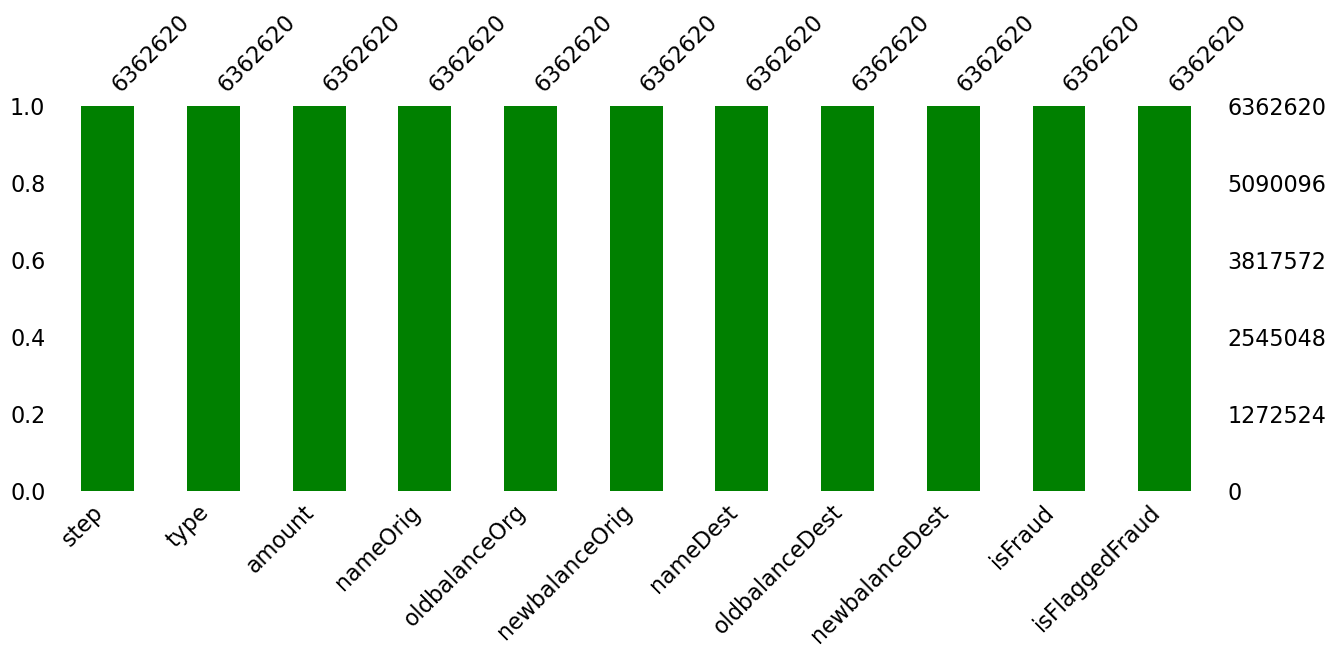

In [5]:
# Check for any missing values in the data.

plt.figure(figsize = (15, 8))
msno.bar(data_df, figsize = (15,5), sort = 'ascending', color = "green")
plt.show()

In [6]:
# Check for any duplicates in the data.

data_df.duplicated().sum()

0

In [7]:
data_df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [8]:
# Drop unwanted columns.

drop_columns = ['step', 'isFlaggedFraud']
data_df = data_df.drop(columns = drop_columns)

In [9]:
# Rename column names for better understanding.

data_df = data_df.rename(columns = {
    'type': 'payment_type',
    'nameOrig': 'origin',
    'oldbalanceOrg': 'sender_old_balance',
    'newbalanceOrig': 'sender_new_balance',
    'nameDest': 'destination',
    'oldbalanceDest': 'receiver_old_balance',
    'newbalanceDest': 'receiver_new_balance',
    'isFraud': 'is_fraud'
})

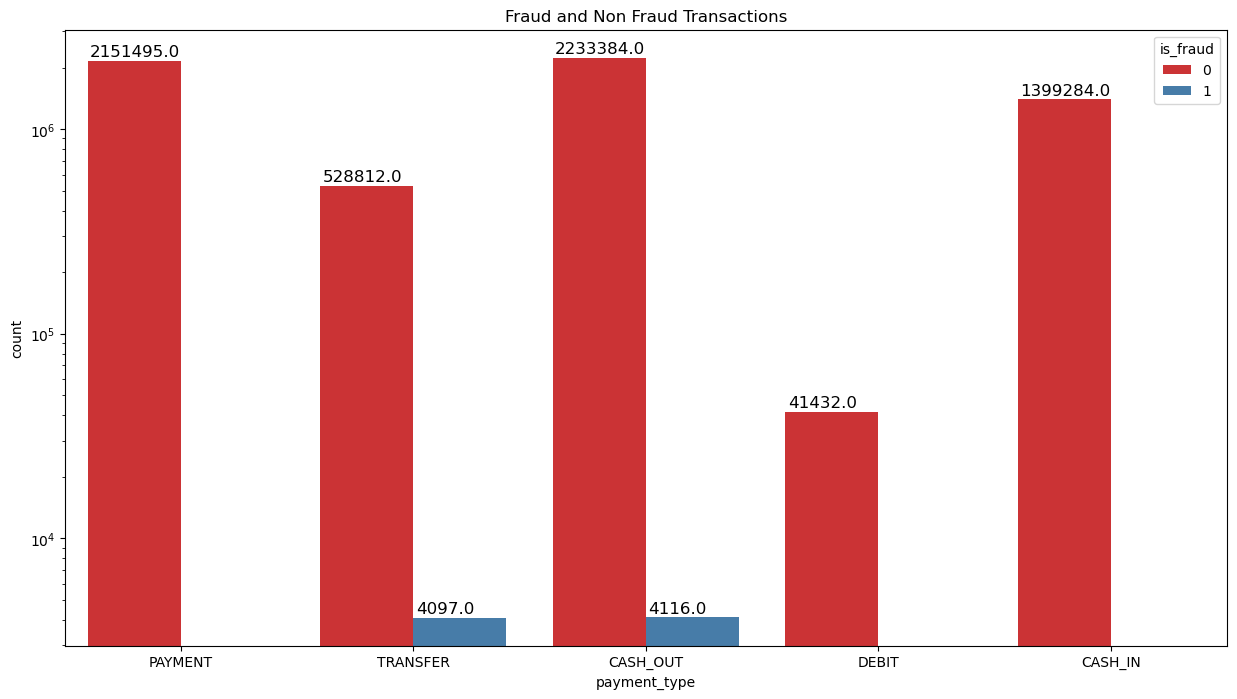

In [18]:
# Visuvalize fraud and non fraud transaction for different payment types.

plt.figure(figsize = (15, 8))
ax=sns.countplot(data = data_df, x = "payment_type", hue="is_fraud", palette = 'Set1')
plt.title('Fraud and Non Fraud Transactions')
ax.set_yscale("log")
for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.01, p.get_height() * 1.05), fontsize=12)

In [11]:
# Check account types of fraud transaction with payment type transfer.

transfer_data = data_df[((data_df['payment_type']=='TRANSFER') & data_df['is_fraud']==1)]
transfer_data['origin'].value_counts()

C1305486145    1
C202278158     1
C12585107      1
C946427395     1
C1069177491    1
              ..
C2090764492    1
C1794935564    1
C318078280     1
C939293281     1
C1685995037    1
Name: origin, Length: 4097, dtype: int64

In [12]:
# Check account types of fraud transaction with payment type transfer.

transfer_data = data_df[((data_df['payment_type']=='CASH_OUT') & data_df['is_fraud']==1)]
transfer_data['origin'].value_counts()

C840083671     1
C1055498407    1
C1886113938    1
C520336445     1
C463684846     1
              ..
C1641368956    1
C2120940829    1
C992121519     1
C1663597987    1
C1280323807    1
Name: origin, Length: 4116, dtype: int64

In [13]:
# Check if transfer receiving account used for cashout.

trans_transfer = data_df[data_df['payment_type'] == 'TRANSER']
trans_cashout = data_df[data_df['payment_type'] == 'CASH_OUT']
trans_transfer.destination.isin(trans_cashout.origin).any()

False

In [14]:
# A total of 4,097 fraudulent transactions occurred in the "TRANSFER" transaction type, and 4,116 fraudulent transactions occurred in the "CASH_OUT" transaction type.

# Most fraudulent transactions involved transfers between customers.

# In cases of fraud, the sender and receiver accounts were not the same for the transactions.

# Fraudulent transactions typically involved different accounts for sending and receiving funds.

In [15]:
# Add another feature to check customer, merchant connection in transaction.

data_df['origin_destination_type'] = data_df['origin'].str[0] + data_df['destination'].str[0]

In [16]:
# Drop origin and destination columns as in fraud transactions they are used only once.

data_df.drop(columns = ['origin','destination'], axis = 'columns', inplace = True)

In [17]:
data_df.head()

,payment_type,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,is_fraud,origin_destination_type
0,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0,CM
1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0,CM
2,TRANSFER,181.00,181.0,0.00,0.0,0.0,1,CC
3,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1,CC
4,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0,CM


In [18]:
# Check how customer, merchant connection impacts fraud.

fraud_trans = data_df[data_df['is_fraud'] == 1]
valid_trans = data_df[data_df['is_fraud'] == 0]

print("Fraud transaction: ")
print(fraud_trans['origin_destination_type'].value_counts())
print("Non fraud transaction: ")
print(valid_trans['origin_destination_type'].value_counts())

Fraud transaction: 
CC    8213
Name: origin_destination_type, dtype: int64
Non fraud transaction: 
CC    4202912
CM    2151495
Name: origin_destination_type, dtype: int64


In [19]:
# There were a total of 8,213 fraudulent transactions, all of which were made between customers.

# A total of 4,202,912 valid transactions occurred between customers.

# Additionally, 2,151,495 valid transactions were made from customers to merchants.

In [20]:
# Convert categorical features using OneHotEncoder.

categorical_columns = ['payment_type', 'origin_destination_type']
encoder = OneHotEncoder()
data_df_encoded = encoder.fit_transform(data_df[categorical_columns])
feature_names = encoder.get_feature_names_out(input_features=categorical_columns)
data_df = pd.concat([data_df.drop(categorical_columns, axis=1), pd.DataFrame(data_df_encoded.toarray(), columns=feature_names)], axis=1)
data_df.head()

,amount,sender_old_balance,sender_new_balance,receiver_old_balance,receiver_new_balance,is_fraud,payment_type_CASH_IN,payment_type_CASH_OUT,payment_type_DEBIT,payment_type_PAYMENT,payment_type_TRANSFER,origin_destination_type_CC,origin_destination_type_CM
0,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,181.00,181.0,0.00,0.0,0.0,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0
3,181.00,181.0,0.00,21182.0,0.0,1,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [21]:
processed_file_path = current_directory + '/input/preprocessed_data.csv'
data_df.to_csv(processed_file_path, index=False)